In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, simulate_choice

In [16]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST"]

# DEFINE MODEL STRUCTURE AND LIKELIHOOD FUNCTION
def log_likelihood_telephone_LM(beta, data):
    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1'] 
    data['U_2'] = beta[4] * data['logcost2'] 
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']

    sum_total = np.exp(data['U_1']) * data['avail1'] + np.exp(data['U_2']) * data['avail2'] + \
                np.exp(data['U_3']) * data['avail3'] + np.exp(data['U_4']) * data['avail4'] + \
                np.exp(data['U_5']) * data['avail5']
    
    # Full probabilities
    data['P_1'] = np.exp(data['U_1']) * data['avail1'] / sum_total
    data['P_2'] = np.exp(data['U_2']) * data['avail2'] / sum_total
    data['P_3'] = np.exp(data['U_3']) * data['avail3'] / sum_total
    data['P_4'] = np.exp(data['U_4']) * data['avail4'] / sum_total
    data['P_5'] = np.exp(data['U_5']) * data['avail5'] / sum_total
    
    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data.loc[data['P'] == 0, 'P'] = epsilon
    
    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [17]:
# Load data
data = pd.read_csv('./data/telephone.dat', sep='\t')

data['logcost1'] = np.log(data['cost1'])
data['logcost2'] = np.log(data['cost2'])
data['logcost3'] = np.log(data['cost3'])
data['logcost4'] = np.log(data['cost4'])
data['logcost5'] = np.log(data['cost5'])

# Define model parameters
beta = np.array([0, 0, 0, 0, 0])

beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST"]


In [18]:
# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data, beta, beta_names, log_likelihood_telephone_LM)

Optimization Results:
   Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0      ASC_1 -0.721243              0.153463    -4.699777  3.514203e-06
1      ASC_3  1.201266              0.154843     7.757947  6.372680e-14
2      ASC_4  0.999199              0.702369     1.422612  1.555754e-01
3      ASC_5  1.736400              0.275862     6.294454  7.631404e-10
4  BETA_COST -2.026204              0.213538    -9.488723  0.000000e+00
AIC: 965.1137706159915
BIC: 985.4789932864935
Log-likelihood: -477.55688530799574


In [19]:
from functions_geom_DIB import geom_DIB_on_alternatives

In [20]:
np.random.seed(123)
data['simulated_choice'] = data.apply(simulate_choice, axis=1)

In [21]:
def multivariate_lognormal_pdf(x, mu, sigma):
    """
    Compute the probability density function (PDF) of a multivariate lognormal distribution.

    Parameters:
        x (ndarray): Vector in log space.
        mu (ndarray): Mean vector.
        sigma (ndarray): Covariance matrix.

    Returns:
        float: Value of the PDF at x.
    """
    n = len(x)
    
    # Compute the PDF of a multivariate normal distribution
    exponent = -0.5 * (x - mu).T @ np.linalg.inv(sigma) @ (x - mu)
    mvn_pdf = (1 / ((2 * np.pi) ** (n / 2) * np.sqrt(np.linalg.det(sigma)))) * np.exp(exponent)
    
    # Compute the Jacobian determinant term and remove x = 0 elements
    jacobian = np.prod(1 / x)

    pdf = jacobian * mvn_pdf

    # Compute the PDF of the multivariate lognormal distribution
    
    return pdf

In [22]:
# Function to calculate the number of elements in the largest cluster
def largest_cluster_size(q_t_given_x):
    # Calculate the size of each cluster
    cluster_sizes = np.sum(q_t_given_x, axis=0)
    # Find the size of the largest cluster
    largest_cluster_size = np.max(cluster_sizes)
    return largest_cluster_size

<h2> We need to change the way we handle missing values for alternative 4 and 5. We take the mean vector by removing the missing values. </h2>

In [139]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]
# Compute the mean vector and covariance matrix
log_df_logcost = np.log(df_logcost)
mean_vector = log_df_logcost.mean()

# Compute the mean for alternative 4 and 5 by removing missing values
true_alt_4 = log_df_logcost['logcost4'] * data['avail4']
true_alt_5 = log_df_logcost['logcost5'] * data['avail5']
true_alt_4 = true_alt_4[true_alt_4 != 0]
true_alt_5 = true_alt_5[true_alt_5 != 0]
mean_vector[3] = true_alt_4.mean()
mean_vector[4] = true_alt_5.mean()

# Compute diagonal covariance matrix 
var1 = log_df_logcost['logcost1'].var()
var2 = log_df_logcost['logcost2'].var()
var3 = log_df_logcost['logcost3'].var()
var4 = true_alt_4.var() * 5
var5 = true_alt_5.var()

cov12 = log_df_logcost['logcost1'].cov(log_df_logcost['logcost2'])
cov13 = log_df_logcost['logcost1'].cov(log_df_logcost['logcost3'])
cov14 = log_df_logcost['logcost1'].cov(true_alt_4)
cov15 = log_df_logcost['logcost1'].cov(true_alt_5)
cov23 = log_df_logcost['logcost2'].cov(log_df_logcost['logcost3'])
cov24 = log_df_logcost['logcost2'].cov(true_alt_4)
cov25 = log_df_logcost['logcost2'].cov(true_alt_5)
cov34 = log_df_logcost['logcost3'].cov(true_alt_4)
cov35 = log_df_logcost['logcost3'].cov(true_alt_5)
cov45 = true_alt_4.cov(true_alt_5)


covariance_matrix = np.array([[var1, cov12, cov13, cov14, cov15],
                              [cov12, var2, cov23, cov24, cov25],
                              [cov13, cov23, var3, cov34, cov35],
                              [cov14, cov24, cov34, var4, cov45],
                              [cov15, cov25, cov35, cov45, var5]])

covariance_matrix_increased = covariance_matrix * 50

# Compute the probability density for each individual's cost vector
df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_increased), axis=1)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_1382/1551397865.py:11: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  mean_vector[3] = true_alt_4.mean()
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_1382/1551397865.py:12: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  mean_vector[4] = true_alt_5.mean()
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_1382/1551397865.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [140]:
np.linalg.eigvals(covariance_matrix_increased)

array([3.21597444e+01, 3.51544586e+00, 2.88164648e-01, 1.25451443e-02,
       9.12906752e-02])

In [141]:
# Computation of p(x,y)
p_x = df_logcost['probability_density'].values

p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

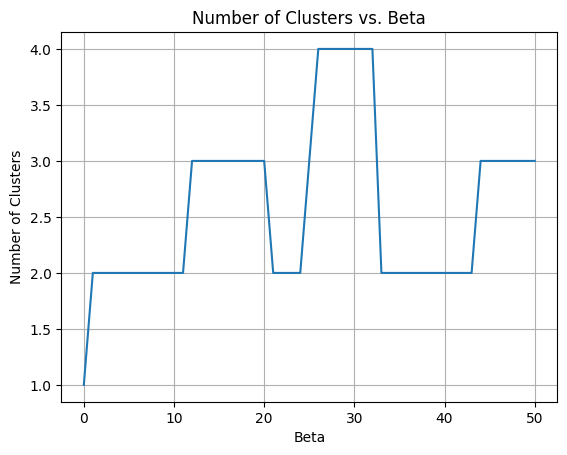

In [151]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []
largest_cluster_sizes = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

        # Calculate the size of the largest cluster
    largest_size = largest_cluster_size(q_t_given_x)
    # Append the size of the largest cluster to the list
    largest_cluster_sizes.append(largest_size)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

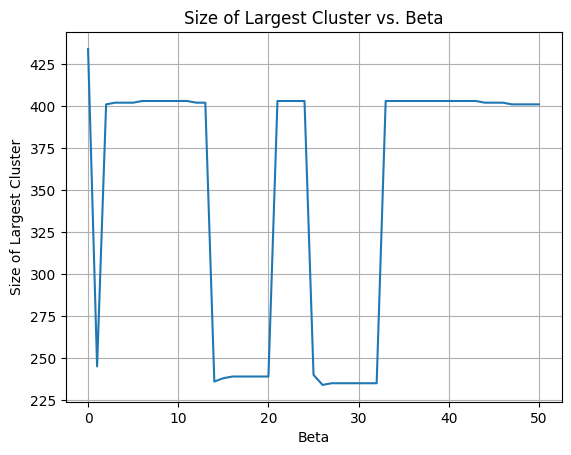

In [152]:
# Plot the number of elements in the largest cluster against beta values
plt.plot(betas, largest_cluster_sizes)
plt.xlabel('Beta')
plt.ylabel('Size of Largest Cluster')
plt.title('Size of Largest Cluster vs. Beta')
plt.grid(True)
plt.show()

In [168]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=50, max_iter=50000, threshold=1e-5)

Iteration: 1 out of 50000
Iteration: 2 out of 50000
Iteration: 3 out of 50000
Iteration: 4 out of 50000
Iteration: 5 out of 50000
Iteration: 6 out of 50000
Iteration: 7 out of 50000
Iteration: 8 out of 50000
Iteration: 9 out of 50000
Iteration: 10 out of 50000
Iteration: 11 out of 50000
Iteration: 12 out of 50000
Iteration: 13 out of 50000
Iteration: 14 out of 50000
Iteration: 15 out of 50000
Iteration: 16 out of 50000
Iteration: 17 out of 50000
Iteration: 18 out of 50000
Iteration: 19 out of 50000
Iteration: 20 out of 50000
Iteration: 21 out of 50000
Iteration: 22 out of 50000
Iteration: 23 out of 50000
Iteration: 24 out of 50000
Iteration: 25 out of 50000
Iteration: 26 out of 50000
Iteration: 27 out of 50000
Iteration: 28 out of 50000
Iteration: 29 out of 50000
Iteration: 30 out of 50000
Iteration: 31 out of 50000
Iteration: 32 out of 50000
Iteration: 33 out of 50000
Iteration: 34 out of 50000
Iteration: 35 out of 50000
Iteration: 36 out of 50000
Iteration: 37 out of 50000
Iteration:

In [169]:

# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 3

 cluster
2    401
4     30
1      3
Name: count, dtype: int64

 choice    1    2    3  4   5
cluster                     
1         0    0    1  0   2
2        72  122  174  3  30
4         1    1    3  0  25

 max_proba   1    2    3  4   5
cluster                       
1           0    0    0  0   3
2          49  110  236  2   4
4           0    0    0  0  30

 simulated_choice   1    2    3  4   5
cluster                              
1                  0    0    1  0   2
2                 71  133  161  3  33
4                  0    2    2  0  26
